In [10]:
import pandas as pd
from lifelines import CoxPHFitter
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
import numpy as np

In [3]:
survival_data_path = Path("/workspaces/nrg_interview_prep/data/survival_data.csv")
survival_data_df = pd.read_csv(survival_data_path)

In [4]:
survival_data_df['E'].value_counts()

E
1    189
0     11
Name: count, dtype: int64

There's not a lot of data (relative few censored/non-events), but I still want to have a small test holdout set.

In [5]:
test_size = 10  # small test you want
rng = np.random.default_rng(seed=17)


censored_idx = survival_data_df.index[survival_data_df['E'] == 0].tolist()
event_idx = survival_data_df.index[survival_data_df['E'] == 1].tolist()

# Ensure atleast one censored data point
chosen = []
chosen.append(rng.choice(censored_idx))


remaining_pool = survival_data_df.index.difference(chosen)
remaining_choices = rng.choice(remaining_pool, size=test_size - 1, replace=False)
chosen.extend(list(remaining_choices))

test_df = survival_data_df.loc[chosen].reset_index(drop=True)
train_df = survival_data_df.drop(index=chosen).reset_index(drop=True)

In [6]:
# Check that the split worked
print("Train set 'E' value counts:")
print(train_df['E'].value_counts())
print("\nTest set 'E' value counts:")
print(test_df['E'].value_counts())

Train set 'E' value counts:
E
1    180
0     10
Name: count, dtype: int64

Test set 'E' value counts:
E
1    9
0    1
Name: count, dtype: int64



=== Cox Proportional Hazards Model Summary ===


<lifelines.CoxPHFitter: fitted with 190 total observations, 10 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 190
number of events observed = 180
   partial log-likelihood = -760.33
         time fit was run = 2025-10-30 03:58:54 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
var1       0.22      1.25      0.07            0.07            0.37                1.08                1.44
var2       0.03      1.03      0.09           -0.14            0.20                0.87                1.22
var3       0.23      1.25      0.08            0.07            0.38                1.08                1.46

           cmp to    z      p  -log2(p)
covariate                              
var1         0.00 2.94 <0.005      8.25
var2         0.00 0.33   0.74      0.43
var3         0.00 2.88 <0.005      7.97
---
Concordance = 0.58
Partial AIC = 1526.66
log-likelihood ratio test = 15.12 on 3 df
-log2(p) of ll-ratio test = 9.19


=== Hazard Ratios (exp(coef)) ===
covariate
var1    1.246392
var2    1.028993
var3    1.254341
Name: exp(coef), dtype: float64
• A one-unit increase in var1 increases the hazard rate (coef=0.220).
• A one-unit increase in var2 increases the hazard rate (coef=0.029).
• A one-unit increase in var3 increases the hazard rate (coef=0.227).


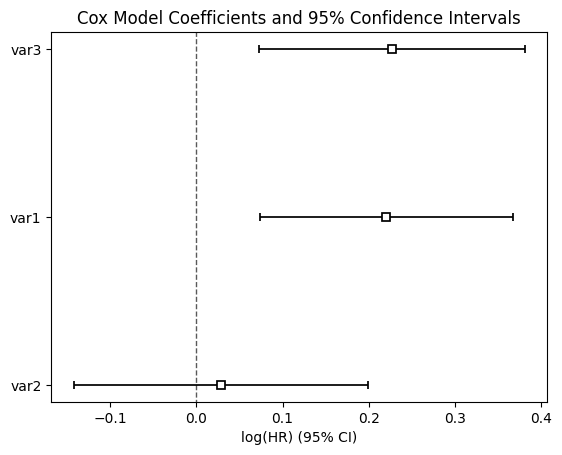

In [7]:
cph = CoxPHFitter()
cph.fit(train_df, duration_col='T', event_col='E')


print("\n=== Cox Proportional Hazards Model Summary ===")
cph.print_summary()  # shows coefficients, p-values, confidence intervals, etc.


print("\n=== Hazard Ratios (exp(coef)) ===")
print(cph.hazard_ratios_)

for var, coef in cph.params_.items():
    if coef > 0:
        direction = "increases"
    elif coef < 0:
        direction = "decreases"
    else:
        direction = "does not affect"
    print(f"• A one-unit increase in {var} {direction} the hazard rate (coef={coef:.3f}).")


cph.plot()
plt.title("Cox Model Coefficients and 95% Confidence Intervals")
plt.show()



In [11]:
# Evaluate using concordance index
test_risk = cph.predict_partial_hazard(test_df)
concordance = concordance_index(
    test_df['T'], -test_risk, test_df['E'])
print(f"Concordance index on test set: {concordance:.3f}")

Concordance index on test set: 0.538


Only slightly better than random guessing . . . definitely need more data and maybe better features, not enough information to know for sure

In [12]:
cph.check_assumptions(train_df)

Proportional hazard assumption looks okay.


[]